In [1]:
import numpy as np
import tensorflow as tf
# next line only for colab
%tensorflow_version 2.x
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

# 1. Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


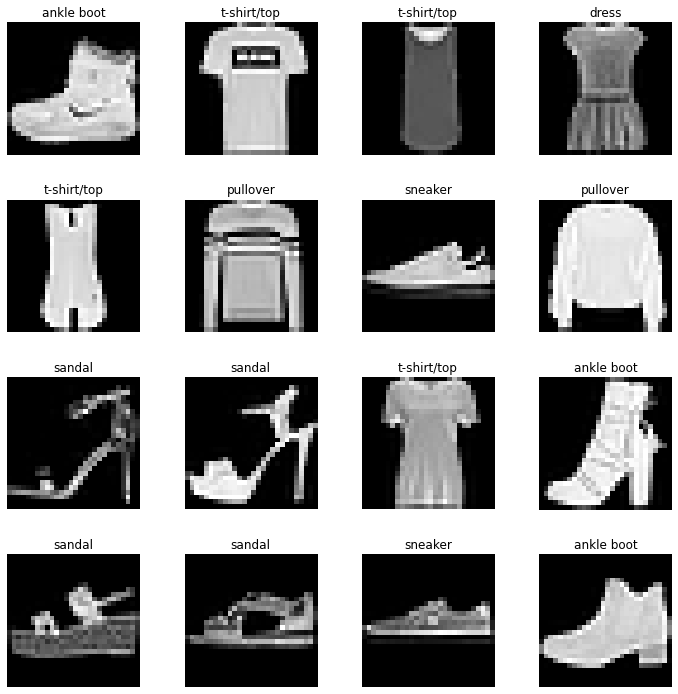

In [3]:
# Plot some images together with their labels
label_names = ["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
fig, ax = plt.subplots(4,4, figsize = (10,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(16):
  ax[i].imshow(train_images[i], cmap = "gray")
  ax[i].set_title(label_names[int(train_labels[i])])
  ax[i].axis('off')

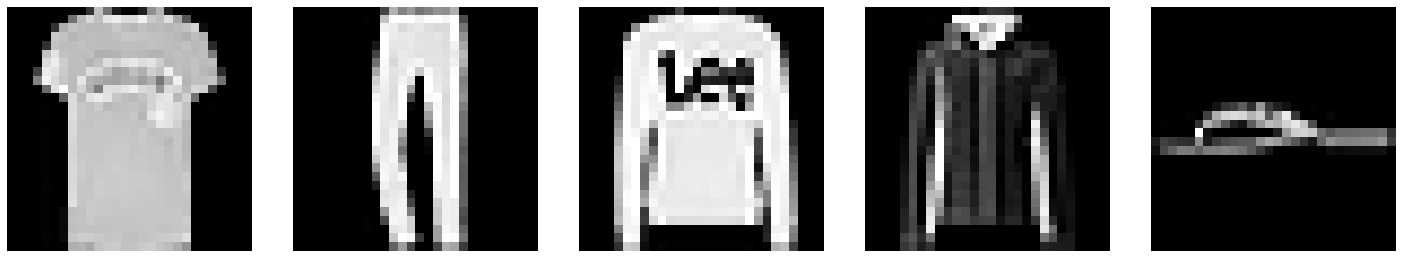

In [4]:
def get_img(label_list):
  """Function to obtain preselected Images of the specified classes from the Test Set 

  Arguments:
    label_list (list): List containing the classes indices 

  Returns:
    imgs_for_network (list): list containing tensors corresponding to images of the specified classes, to be feeded into the Autoencoder 
                             --> additional batch and channel dimensions have been added 
    imgs_for_visualization (list): list containing the images to compare the Autoencoders perfomance to the original input
  """
  idx = [np.where(test_labels == label)[0][0] for label in label_list]
  imgs_for_network = [tf.cast(tf.expand_dims(tf.expand_dims(test_images[index]/255,-1),0), tf.float32) for index in idx]
  imgs_for_visualization = [tf.cast(test_images[index]/255, tf.float32) for index in idx]
  return imgs_for_network, imgs_for_visualization

imgs_for_network, imgs_for_visualization = get_img([0,1,2,4,5])

# plot the preselected images which are later used for evaluating the Autoencoders perfomance on
fig, ax = plt.subplots(1,5, figsize = (20,20))
fig.tight_layout()
ax = ax.flatten()
for i in range(5):
  ax[i].imshow(imgs_for_visualization[i], cmap = "gray")
  ax[i].axis('off')

## Input pipeline


In [5]:
# Since we are dealing with an Autoencoder we do not need the labels in our train and test datasets
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

# We normalize the images to a scale between 1 and 0.
# Furthermore, we use the .cache() function to store the data we need later in our memory for faster training 
train_dataset = train_dataset_images.map(lambda img: tf.cast(tf.expand_dims(img/255,-1), tf.float32)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(60).prefetch(tf.data.experimental.AUTOTUNE)


# Repeat for test data
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset_images.map(lambda img: tf.cast(tf.expand_dims(img/255,-1), tf.float32)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(50).prefetch(tf.data.experimental.AUTOTUNE)

# 2. Model

## 2.1 Convolutional Autoencoder

In [22]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Encoder(Model):

  def __init__(self, embedding_size, num_filters, kernel_size=3):
    """Initialize a Convolutional Encoder that creates an embedding of the input

    Arguments:
      embedding_size (int): Defines the size (dimensions) of the resulting embedding
      num_filters (list): Contains the number of filters for the hidden convolutional layers
      kernel_size (int): Used to set the kernel size of the hidden convolutional layers, set per default to 3
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(Encoder, self).__init__()

    # extract the filters for our conv layers
    self.filter1, self.filter2 = num_filters

    self.EncoderLayers = [
        tf.keras.layers.Conv2D(filters=self.filter1, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Conv2D(filters=self.filter2, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=embedding_size, activation="relu")
        ]

  @tf.function    
  def call(self, x, training = True):
    """Activate our Encoder propagating the input through it layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Encoder
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Encoder 

    Returns:
      x (Tensor): Tensor containing the resulting embedding of the input 
    """
    for layer in self.EncoderLayers:
      x = layer(x, training = training)
    return x

In [23]:
class Decoder(Model):

  def __init__(self, num_filters, kernel_size=3):
    """Initialize a Convolutional Decoder that works on the embeddings via Upscaling and Reshaping in order to recreate the Image

    Arguments:
      num_filters (list): Contains the number of filters for the hidden convolutional layers
      kernel_size (int): Used to set the kernel size of the hidden convolutional layers, set per default to 3
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(Decoder, self).__init__()

    # extract the filters for our conv layers
    self.filter1, self.filter2 = num_filters

    self.DecoderLayers = [
        # we need as many units in this Dense Layer as we need pixels for our images, here 7x7 Images with 64 feature maps, such that we can reshape this Layer 
        tf.keras.layers.Dense(units=49*64, activation="relu"), 
        tf.keras.layers.Reshape(target_shape=(7,7,64)),
        tf.keras.layers.Conv2DTranspose(filters=self.filter1, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Conv2DTranspose(filters=self.filter2, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding="same",  activation="sigmoid")
        ]

  @tf.function    
  def call(self, x, training = True):
    """Activate our Decoder propagating the input through the it layer by layer

    Arguments:
      x (Tensor): Tensor containing the embedded input
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Decoder 

    Returns:
      x (Tensor): Tensor containing the recreated Images from the input Embeddings
    """
    for layer in self.DecoderLayers:
      x = layer(x, training = training)
    return x

In [24]:
class AutoEncoder(Model):

  def __init__(self, embedding_size, num_filters):
    """Initialize a Convolutional Autoencoder consisting of an Encoder and Decoder

    Arguments:
      embedding_size (int): Determines the size of our embedding
      num_filters (list): Contains the numbers of filters for our Encoder and the Decoder (the Decoder receives the list in reversed order)
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(AutoEncoder, self).__init__()

    self.Encoder = Encoder(embedding_size=embedding_size, num_filters=num_filters)
    self.Decoder = Decoder(num_filters=num_filters[::-1])


  @tf.function    
  def call(self, x, training = True):
    """Activate our Autoencoder propagating the input through the Encoder and Decoder respectively

    Arguments:
      x (Tensor): Tensor containing the input to our Autoencoder
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Autoencoder 

    Returns:
      x (Tensor): Tensor containing the recreated Images
    """
    x = self.Encoder(x)
    x = self.Decoder(x)
    return x

## 2.2 Variational Autoencoder

### Prior

In [58]:
# We decided to use tensorflow probability for our VAE
import tensorflow_probability as tfp
tfd = tfp.distributions

# Our embedding size
embedding_size = 10

# Specify the prior for the KLDivergenceRegularizer
# We create an independent normal distribution with no learned parameters, our latent variable has 10 dimensions.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(embedding_size), scale=1), reinterpreted_batch_ndims=1)

In [59]:
class VaEncoder(Model):

  def __init__(self, embedding_size, num_filters, kernel_size=3):
    """Initialize a Convolutional Encoder that creates a multivariate normal distribution with as many parameters as the embedding size

    Arguments:
      embedding_size (int): Defines the size (dimensions) of the resulting embedding
      num_filters (list): Contains the number of filters for the hidden convolutional layers
      kernel_size (int): Used to set the kernel size of the hidden convolutional layers, set per default to 3
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(VaEncoder, self).__init__()

    # extract the filters for our conv layers
    self.filter1, self.filter2 = num_filters

    self.EncoderLayers = [
        tf.keras.layers.Conv2D(filters=self.filter1, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Conv2D(filters=self.filter2, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Flatten(),
        # Create the mu and sigma vectors for the multivaraite normal distribution 
        # Use KLDivergenceRegularizer in the Encoder to enforce that the normal distributions are similar to the standard normal (0,1)
        # Furthermore, the convert_to_tensor_fn is set to tfd.Distribution.sample. This means that each time we treat the output of the encoder as a tensor (which we do in our decoder)
        # the embedding will be sampled from the multivariate normal distribution (normally the output would be the distribution itself)
        tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(embedding_size), activation=None),
        tfp.layers.MultivariateNormalTriL(embedding_size, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1), convert_to_tensor_fn=tfd.Distribution.sample)
        ]

   
  def call(self, x):
    """Activate our Encoder propagating the input through it layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Encoder
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Encoder 

    Returns:
      x (Tensor): Tensor containing the resulting parameters 
    """
    for layer in self.EncoderLayers:
      x = layer(x)
    return x

In [60]:
class VaDecoder(Model):

  def __init__(self, num_filters, kernel_size=3):
    """Initialize a Convolutional Decoder that works on the sampled embeddings via Upscaling and Reshaping in order to recreate the Image

    Arguments:
      num_filters (list): Contains the number of filters for the hidden convolutional layers
      kernel_size (int): Used to set the kernel size of the hidden convolutional layers, set per default to 3
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(VaDecoder, self).__init__()

    # extract the filters for our conv layers
    self.filter1, self.filter2 = num_filters

    self.DecoderLayers = [
        # we need as many units in this Dense Layer as we need pixels for our images, here 7x7 Images with 64 feature maps, such that we can reshape this Layer 
        tf.keras.layers.Dense(units=49*64, activation="relu"), 
        tf.keras.layers.Reshape(target_shape=(7,7,64)),
        tf.keras.layers.Conv2DTranspose(filters=self.filter1, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        tf.keras.layers.Conv2DTranspose(filters=self.filter2, kernel_size=kernel_size, strides=2, padding="same",  activation="relu"),
        # the last layer has no activation function due to the used loss function (negative_log_likelihood)
        tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding="same", activation=None),
        tf.keras.layers.Flatten(),
        tfp.layers.IndependentBernoulli((28,28,1), tfd.Bernoulli.logits)
        ]


  def call(self, x):
    """Activate our Decoder propagating the input through the it layer by layer

    Arguments:
      x (Tensor): Tensor containing the embedded input
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Decoder 

    Returns:
      x (Tensor): Tensor containing the recreated Images from the input Embeddings
    """
    for layer in self.DecoderLayers:
      x = layer(x)
    return x

In [61]:
class VaAutoEncoder(Model):

  def __init__(self, embedding_size, num_filters):
    """Initialize a Convolutional Autoencoder consisting of an Encoder and Decoder

    Arguments:
      embedding_size (int): Determines the size of our embedding
      num_filters (list): Contains the numbers of filters for our Encoder and the Decoder (the Decoder receives the list in reversed order)
    """  
    # use the keyword super to allow our network to access the init() from the keras Model class
    super(VaAutoEncoder, self).__init__()

    self.Encoder = VaEncoder(embedding_size=embedding_size, num_filters=num_filters)
    self.Decoder = VaDecoder(num_filters=num_filters[::-1])


  #@tf.function    
  def call(self, x):
    """Activate our Autoencoder propagating the input through the Encoder and Decoder respectively

    Arguments:
      x (Tensor): Tensor containing the input to our Autoencoder
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Autoencoder 

    Returns:
      x (Tensor): Tensor containing the recreated Images
    """
    x = self.Encoder(x)
    x = self.Decoder(x)
    return x

### New loss function for VAE

In [62]:
# use the function below to compute the negative_log_likelihood of the elbo loss --> use this as our reconstruction loss 
# since the last layer of our decoder is a tf probability layer that return a distribution, we can use .log_prob() 
negative_log_likelihood = lambda target, prediction: -prediction.log_prob(target)

# 3. Training and Analysis

In [63]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
  """Perform a training step for a given Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets (just the input)
  2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 
 
  Arguments:
    model (Model): given instance of an initialised  Network with all its parameters
    input (EagerTensor): Tensor containing the input data 
    target (EagerTensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss (EagerTensor): Tensor containing the loss of the Network 
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input)
    # 2.
    # complete ELBO loss by adding weighted KL divergence (obtained via model.losses as it is used in the Encoder as a regularizer) to the expected negative log likelihood (our loss function)
    loss = loss_function(target, prediction)+tf.reduce_sum(model.losses)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
  return loss


def test(model, test_data, loss_function):
  """Tests the models loss over the given data set with a given loss_function
 
  Arguments:
    model (Model): given instance of an initialised Network with all its parameters
    test_data (Dataset): test dataset to test the NN on 
    loss_function (keras.losses): function from keras to calculate the loss 
 
  Returns:
    test_loss (float): Average loss of the Network over the test set
  """
  # test over complete test data
  test_loss_aggregator = []
  
  for input in test_data:
    prediction = model(input)
    # calculates the loss value (as a tensors) for an entire batch 
    sample_test_loss = loss_function(input, prediction)+tf.reduce_sum(model.losses)
    

    # take the mean over each boolean array to obtain the average accuracy for one batch 
    test_loss_aggregator.append(sample_test_loss)
 
  test_loss = np.mean(test_loss_aggregator)
  
  return test_loss

In [64]:
def timing(start):
  """Function to time the duration of each epoch

  Arguments:
    start (time): Start time needed for computation 
  
  Returns:
    time_per_training (time): Rounded time in seconds 
  """
  now = time.time()
  time_per_training_step = now - start
  return round(time_per_training_step, 4)

In [65]:
def visualization(train_losses, test_losses, input_img, prediction_img, num_epochs): 
  """Visualize performance and loss for training and test data. 
  
  Arguments:
    train_losses (list): List containing the training losses of the Network
    test_losses (list): List containing the losses of the Network over the test data
    input_img (list): List of input images for visualizing the progress of the Network 
    prediction_img (list): List of recreated images for visualizing the progress of the Network 
    num_epochs (int): Number of Epochs needed for the Caption of the plots
  """ 
  
  # change the style of the plots to a nicer theme
  plt.style.use('ggplot')

  # first plot for visualizing the average loss over the training and test data
  fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))
  ax1.plot(train_losses, label='training')
  ax1.plot(test_losses, label='test')
  ax1.set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
  ax1.legend()


  # plots to evaluate the Autoencoders performance
  fig, ax = plt.subplots(5,2, figsize = (12.4,12.4))
  fig.tight_layout()
  for i in range(5):
    ax[i][0].imshow(input_img[i], cmap = "gray")
    ax[i][0].axis('off')
    ax[i][1].imshow(prediction_img[i], cmap = "gray")
    ax[i][1].axis('off')
  ax[0][0].set(title='Original Input Images')
  ax[0][1].set(title='Recreated Input Images')

  plt.show()

In [66]:
def trainModel(network, name, loss_function, num_epochs=20, learning_rate=0.001, running_average_factor=0.95): 
  """Function that implements the training algorithm for a given Network.
  Prints out useful information and visualizations per epoch.

  Arguments:
    network (Model): Model that the training algorithm should be applied to
    name (string): Name of the model later used for saving the model
    loss_function (keras.losses): To be applied loss_function during training
    num_epochs (int): Defines the amount of epochs the training is performed
    learning_rate (float): To be used learning rate, per default set to 0.001
    running_average (float): To be used factor for computing the running average of the trainings loss, per default set to 0.95
  """ 
  # From IPython.display we import clear_output() in order to be able to clear the print statements after each epoch
  from IPython.display import clear_output

  tf.keras.backend.clear_session()

  ### Hyperparameters
  num_epochs = num_epochs
  learning_rate = learning_rate
  running_average_factor = running_average_factor
  
  # Initialize the model.
  model = network

  # Initialize the loss: categorical cross entropy.
  loss_function = loss_function
  # Initialize the optimizer: Adam with default parameters.
  optimizer = tf.keras.optimizers.Adam()
  
  # Initialize lists for later visualization.
  train_losses = []
  test_losses = []
  
  # testing once before we begin on the test data
  test_loss = test(model=model, test_data=test_dataset, loss_function=loss_function)
  test_losses.append(test_loss)
  
  # check how model performs on train data once before we begin
  train_loss = test(model=model, test_data=train_dataset, loss_function=loss_function)
  train_losses.append(train_loss)

  # We train for num_epochs epochs.
  for i, epoch in enumerate(range(num_epochs)):
      
      start = time.time()

      # training (and checking in with training)
      running_average = 0
      for input in train_dataset:
          # call train_step where input and target are both set to the input --> we want our Autoencoder to recreate the original input
          train_loss = train_step(model=model, input=input, target=input, loss_function=loss_function, optimizer=optimizer)
          # when training the VAE we have to take the mean of the train_loss since our negative_log_likelihood loss function cannot deal with an array of loss values
          # this is not a problem for the ConvAE since we use MSE as a loss function
          if (name == "ConvAE"):
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss

          if (name == "VAE"):
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * np.mean(train_loss)
      train_losses.append(running_average)
  
      # testing
      test_loss = test(model=model, test_data=test_dataset, loss_function=loss_function)
      test_losses.append(test_loss)
      
      # We print useful information about each epoch
      clear_output()
      print('Epoch: __ ' + str(epoch+1))      
      print()
      print(f"This epoch took {timing(start)} seconds")
      print()

      # in each epoch we feed our five preselected images into the Autoencoder, in order to visualize the training progress and accuracy 
      # for later visualization, we have to get rid of the batch and channel dimension --> tf.squeeze()
      # when training the VAE we have to apply sigmoid to the models output since the last layer in the VaDecoder has no activation function 
      if (name == "ConvAE"):
        recreated_imgs = [tf.squeeze(model(img)) for img in imgs_for_network]
        visualization(train_losses=train_losses, test_losses=test_losses, input_img=imgs_for_visualization, prediction_img=recreated_imgs, num_epochs=num_epochs)

      if (name == "VAE"):
        recreated_imgs = [tf.squeeze(tf.nn.sigmoid(model(img))) for img in imgs_for_network]
        visualization(train_losses=train_losses, test_losses=test_losses, input_img=imgs_for_visualization, prediction_img=recreated_imgs, num_epochs=num_epochs)

  print()
  model.summary()


Epoch: __ 20

This epoch took 6.7179 seconds



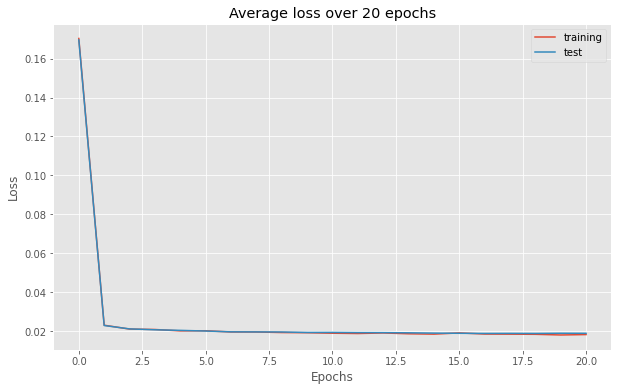

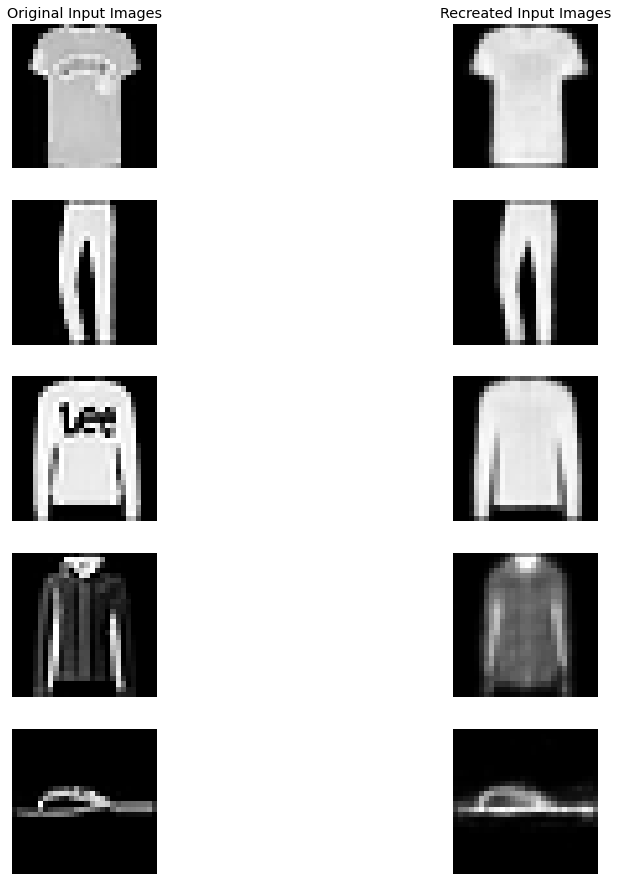


Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  137226    
_________________________________________________________________
decoder (Decoder)            multiple                  182721    
Total params: 319,947
Trainable params: 319,947
Non-trainable params: 0
_________________________________________________________________


In [18]:
ConvAE = AutoEncoder(embedding_size=10, num_filters=[64,128])
trainModel(ConvAE,loss_function=tf.keras.losses.MeanSquaredError(), name="ConvAE")

Epoch: __ 20

This epoch took 14.6039 seconds



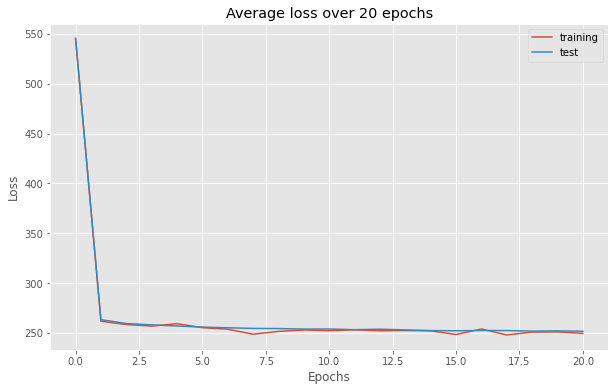

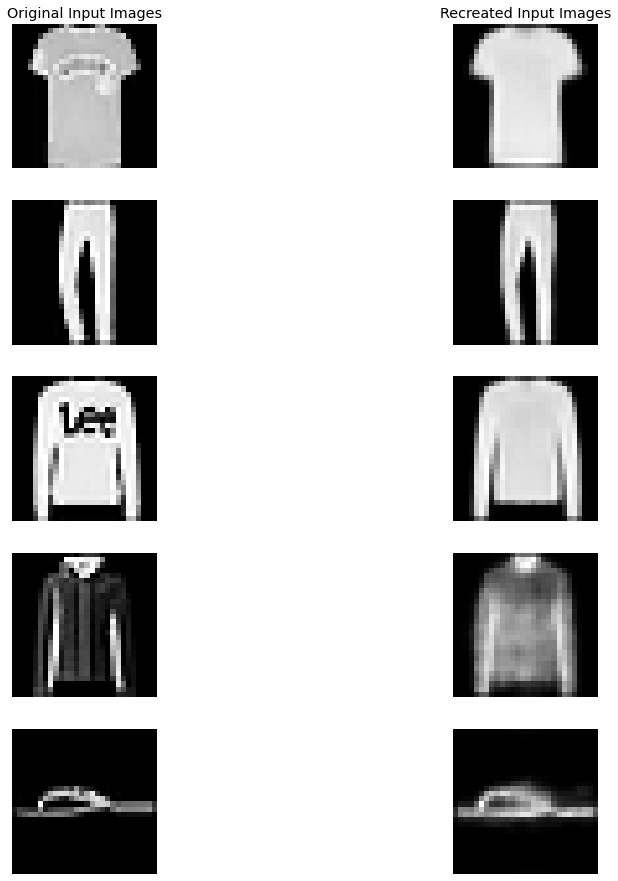


Model: "va_auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
va_encoder (VaEncoder)       multiple                  482241    
_________________________________________________________________
va_decoder (VaDecoder)       multiple                  182721    
Total params: 664,962
Trainable params: 664,962
Non-trainable params: 0
_________________________________________________________________


In [67]:
VAE = VaAutoEncoder(embedding_size=10, num_filters=[64,128])
trainModel(VAE, loss_function=negative_log_likelihood, name="VAE")

# 4. Latent Space Analysis

In [44]:
from sklearn.manifold import TSNE
# We use bokeh plotting for interactive plotting
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Spectral10                   # color palette
from bokeh.models import ColumnDataSource               # allows creating a column dataset for convenient plotting
from bokeh.transform import factor_cmap                 # to apply color palette to our 10 classes
from bokeh.io import output_notebook                    # allows to display the bokeh plot in colab
output_notebook()

label_names = ["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

# We extract eh first 1000 test images and labels
# We normalize the images and add a batch and channel dimension to be able to feed them into the Encoder
latent_space_images = [tf.cast(tf.expand_dims(tf.expand_dims(test_images[i]/255,-1),0), tf.float32) for i in range(1000)]
latent_space_labels = [label_names[int(entry)] for entry in test_labels[:1000]]

def interpolate_embeddings(embedding1, embedding2, n_steps=10):
  """Function that linearlly interpolates between two embeddings 

  Arguments:
    embedding1 (EagerTensor): tensor containing the embedding of the first test image 
    embedding2 (EagerTensor): Tensor containing the embedding of the second test image
    n_steps (int): Defines the number of interpolated embeddings
  
  Returns:
    interpolation_list (list): List of length n_steps, containing the interpolated embeddings between embedding1 and embedding2 
  """
  # define the interpolation ratios based on n_steps
  ratios = np.linspace(0, 1, num=n_steps)
  # linear interpolate embeddings
  interpolation_list = [(1.0 - ratio) * embedding1 + ratio * embedding2 for ratio in ratios]
  return interpolation_list


def get_indices(label_list):
  """Function to retreive the indices of the desired classes

  Arguments:
    label_list (list): List containing the two desired classes 

  Returns:
    idx (list): List of indices of the first appearence of the respective classes
  """
  idx = [np.where(test_labels == label)[0][0] for label in label_list]
  return idx

def latent_space_analysis(network, name, classes):
  """Plot 2D TSNE Embedding and linear interpolation for a given Autoencoder

  Arguments:
    network (model): Model for which the latent space analysis should be conducted
    name (string): Name of the model used to differentiate betweeen the VAE and ConvAE
    classes (list): Classes used for interpolation
  """
  # get the embeddings of the first 1000 images from our test set
  test_images_embeddings = [tf.reshape(network.Encoder(img), (-1,)) for img in latent_space_images]

  # We apply the TSNE algorithm from scikit to get a 2D embedding of our latent space
  tsne = TSNE(n_components=2, random_state=0)
  tsne_embedding = tsne.fit_transform(test_images_embeddings)


  # plotting
  p = figure(tools="pan,wheel_zoom,reset,save",
            toolbar_location="above",
            title="2D Encoder Embeddings of first 1000 Test Images")

  # Create column dataset from the tsne embedding and labels
  source = ColumnDataSource(data=dict(x1=tsne_embedding[:,0],
                                      x2=tsne_embedding[:,1],
                                      names=latent_space_labels))

  # Create a scatter plot from the column dataset above
  p.scatter(x="x1", y="x2", size=6, source=source, fill_color=factor_cmap('names', palette=Spectral10, factors=label_names), fill_alpha=0.4, line_color=factor_cmap('names', palette=Spectral10, factors=label_names), legend_field='names') 

  show(p)

  # specify in the list the two classes that you want to interpolate
  # in this case we chose ankle boot (9) and sandal (5)
  indices = get_indices(classes)

  # call interpolate_embeddings with two test image embeddings
  interpolations = interpolate_embeddings(test_images_embeddings[indices[0]], test_images_embeddings[indices[1]])

  # plot the interpolated images
  fig, ax = plt.subplots(1, 10, figsize = (30,30))
  fig.tight_layout()
  for i in range(10):
    # feed the interpolated embeddings into our Decoder, for that we have to readjust the shape
    # before plotting for the VAE we have to apply sigmoid to the models output since the last layer in the VaDecoder has no activation function 
    if (name == "ConvAE"): 
      img=network.Decoder(tf.reshape(interpolations[i],(1,10)))
    if (name == "VAE"):
      img=tf.nn.sigmoid(network.Decoder(tf.reshape(interpolations[i],(1,10))))
    # before plotting we have to get rid of the batch and channel dimension --> tf.squeeze()
    ax[i].imshow(tf.squeeze(img), cmap = "gray")
    ax[i].axis('off')
  plt.show()

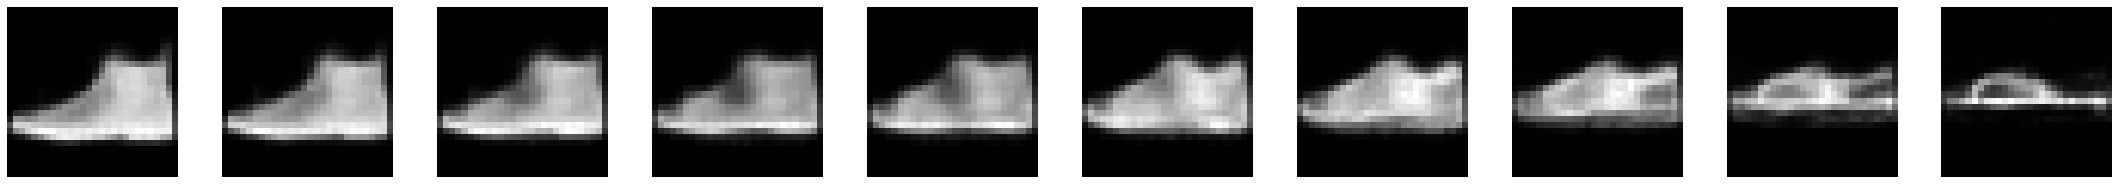

In [35]:
latent_space_analysis(network=ConvAE, name="ConvAE", classes=[9,5])

## Embedding Evaluation ConvAE
The scatter plot looks as one might expect when thinking about the similarity in shape between all ten classes. The embeddings of classes that are similar in shape (pullover & tshirt & coat or ankle boot & sandal & sneaker) are in close proximity or even overlapping and therefore not perfectly distinguishable. However, the combined embeddings of both groups are quite far away as their shapes are very dissimilar.

Classes with more unique shapes like trousers and bag are fairly well separated from the rest.

## Embedding Comparision to VAE
Comparing the Embedding space from the ConvAE and the VAE we can, as expected, see that the VAE embedding is more dense due to the KLD regularizer that enforces the multivariate normal distribution to follow a standard normal.

## Interpolation Comparison
Looking at the interpolation images of both models, we can see that they are able produce somewhat convincing images from (semi-)random vectors (interpolated embddings). We would have expected more pronounced difference here. Still, one can spot minor differences when looking at the second to last image (ConvAE) compared to the third to last image (VAE). I.e. for the ConvAE we see two overlaying images where the features of both classes are visible. For the VAE however, it seems more like two images are vertically glued together (in the left half features of the sandal are present and in the right half we see features of the boot).





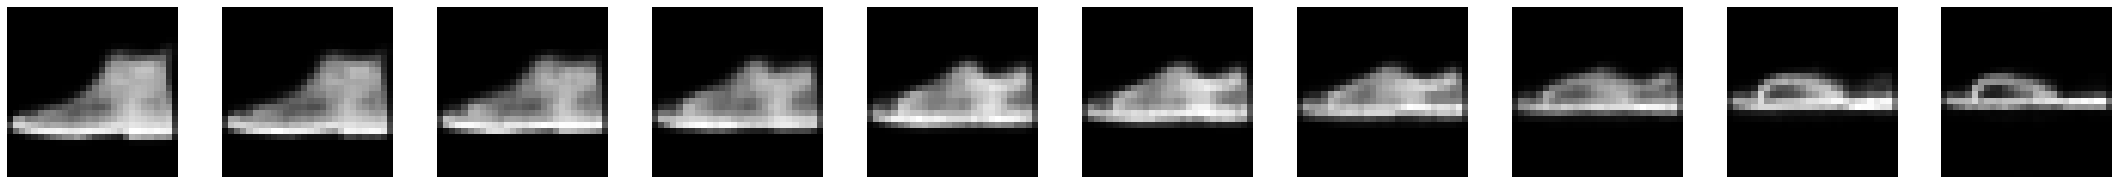

In [68]:
latent_space_analysis(network=VAE, name="VAE", classes=[9,5])